In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
import os
from data_preprocessing import FilteringCurves, ShowResponseCurves
from fitting_curves import FittingColumn, ShowResponseCurvesWithFitting, compute_r2_score
_FOLDER = "./data/"

### normalised_dose_response_data.csv

In [3]:
drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")
drug_curves.shape

(225384, 44)

In [4]:
conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

### Filtering

**Filtering_curves**
<br>(df, response_columns, filtering_scenario = [1,2,3], 
     first_columns_to_compare = [1, 2], last_columns_to_compare = [-1, -2], tolerance=0.05, 
     first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

    filtering_scenario = [1,2,3]
    1. Ensure that all the response are less than 1
    
    2. Ensure that first and last points form a plateu
    the minimal number of points are specified in the function arguments
    by default, two points for both lpateus are considered
    tolerance =0.05 values to ensure the points form a plateu
    first_columns_to_compare = [1, 2]  - first two columns for plateu
    last_columns_to_compare = [-1, -2] - last two columns for plateu
    
    3. Specify location of the plateus - first_points_lower_limit and last_points_upper_limit

In [5]:
def FittedData(df, x_columns, y_columns, fitting_function, parameters_guess=[], default_param = True):
    
    r2, fit_param = FittingColumn(df, df.index, x_columns, y_columns, fitting_function, default_param = True)
    df["fitting_r2"] = r2
    df["fitting_param"] = fit_param
    df= df[df["fitting_r2"]!=0]
    return df

def TransposeCellFeatures(df, indexes_first_column = True):
    # columns in cell_features correspond to drug_curves["COSMIC_ID"] == cell line id
    if indexes_first_column:
        df_transfromed = pd.DataFrame(data= df[df.columns[1:]].values.T,
                          index= df.columns[1:], columns= df[df.columns[0]].values)
    else:
        print("The logic of this function is not applicable")
        
    return df_transfromed 

def PrepareDrugMerge(df):
    """Column fitting_param is splitted into separate columns """
    conc_columns= ["fd_num_"+str(i) for i in range(10)]
    response_norm = ['norm_cells_'+str(i) for i in range(10)]
    param_cols = ["DRUG_ID"] + conc_columns + response_norm
    for i in range(len(df['fitting_param'].values[0])):
        param_col = "param_"+str(i+1)
        param_cols.append(param_col)
        df[param_col] = df['fitting_param'].apply(lambda x: x[i])
    param_cols.insert(0, "COSMIC_ID")
    return df[param_cols]
    

def MergeDrugCells(df_drugs, df_cells):
    cell_features_T = TransposeCellFeatures(df_cells)
    cell_features_T.index = np.array(cell_features_T.index, dtype = "int")
    
    # Not all the drugs from filtered dataset are present in cell lines features
    common_cells_drug = list(set(np.array(df_cells.columns[1:], dtype="int"))& set(df_drugs["COSMIC_ID"].values))
    
    # print("Number of drugs in filtered dataset:", df_328["COSMIC_ID"].nunique())
    # print("Number of common drugs in both datasets", len(common_cells_drug328))

    cell_lines = cell_features_T.loc[common_cells_drug, :].reset_index()
    cell_lines.rename(columns = {"index": "COSMIC_ID"}, inplace=True)
    
    df_drug_param = PrepareDrugMerge(df_drugs)
    
    # merge drug profile data (fitted parameters) and cell line features
    return pd.merge(left=df_drug_param, right = cell_lines, on = "COSMIC_ID") 

In [6]:
%%time
df123 = FilteringCurves(drug_curves, response_norm, first_points_lower_limit = 0.8, last_points_upper_limit = 0.4)

Original dataset: (225384, 44)
1st filtration (Ensure that all the response are less than 1): Filtered dataset: (63325, 44)
2d filtration (Ensure that first and last points form plateus): Filtered dataset: (6321, 46)
3d stage filtration (Specified location of the plateus): Filtered dataset: (2776, 46)
CPU times: user 961 ms, sys: 230 ms, total: 1.19 s
Wall time: 1.58 s


In [7]:
not_fitted_df = df123.copy()
fitting_function = "sigmoid_4_param"
df = FittedData(not_fitted_df, x_columns=conc_columns, y_columns= response_norm, 
                fitting_function=fitting_function, default_param_number=4)
print("Fitted data with removed unfit", df.shape)

100%|██████████| 2776/2776 [00:11<00:00, 233.99it/s]

Fitted data with removed unfit (2749, 48)


Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


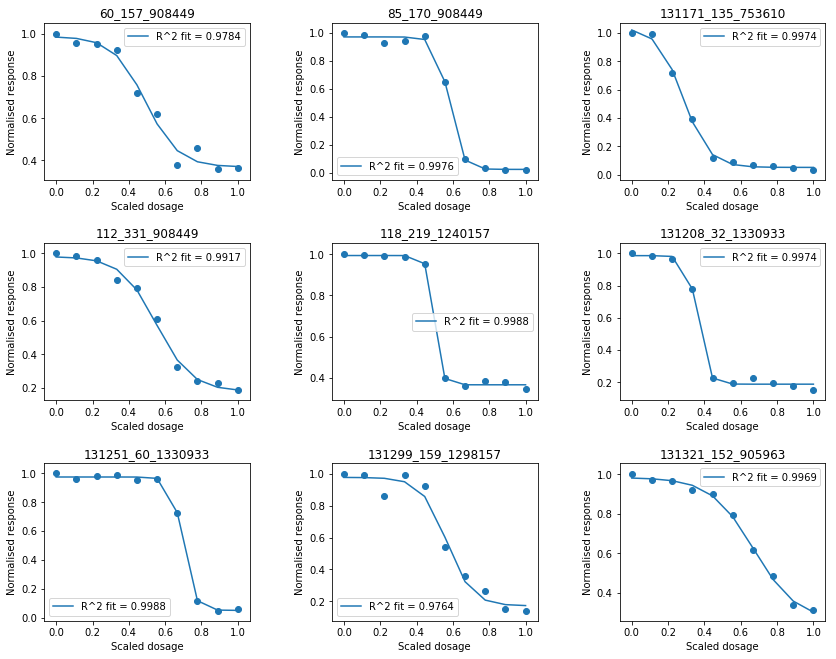

In [8]:
fitting_function = "sigmoid_4_param"
fit_columns = "fitting_param"

ShowResponseCurvesWithFitting(df, plots_in_row=3, plots_in_column=3, x_columns=conc_columns, 
                              y_columns = response_norm, indexes=df.index[:9], 
                              fitting_function = fitting_function, fitting_parameters = fit_columns)

In [9]:
df123.groupby("DRUG_ID")[["DRUGID_COSMICID"]].count().sort_values("DRUGID_COSMICID", ascending =False).head(10)

,DRUGID_COSMICID
DRUG_ID,
328,118
272,116
273,115
274,109
276,109
170,107
200,93
219,92
180,79


### Many drugs

In [32]:
cell_features = pd.read_csv(_FOLDER+"Cell_Line_Features_PANCAN_simple_MOBEM.tsv", sep="\t")
merged_df = MergeDrugCells(df, cell_features)

for i in range(4):
    merged_df["pred_param_"+str(i+1)] = np.zeros(merged_df.shape[0])

In [36]:
%%time

# Check the errors for all drugs
df_errors = pd.DataFrame()

gr = df123.groupby(["DRUG_ID"])["DRUGID_COSMICID"].count()
df_errors["DRUG_ID"] = gr[gr>70].index

df_errors.set_index("DRUG_ID", inplace =True)

for drug_id in df_errors.index:
    merged_df_i = merged_df[merged_df["DRUG_ID"]==drug_id]
    # merged_df_i has lower shape
    np.random.seed(123)
    indexes = np.random.permutation(merged_df_i.index)
    train_size = int(merged_df_i.shape[0]*0.7)
    indexes_train = indexes[:train_size]
    indexes_test= indexes[train_size:]
    X_train = merged_df_i.loc[indexes_train, merged_df_i.columns[26:-4]].values
    X_test = merged_df_i.loc[indexes_test, merged_df_i.columns[26:-4]].values
    X = merged_df_i[merged_df_i.columns[26:-4]].values
    
    for i in range(4):
        y_train = merged_df_i.loc[indexes_train, "param_"+str(i+1)]
        y_test = merged_df_i.loc[indexes_test, "param_"+str(i+1)]
#         print(y_test)
        
        kr_lin = KernelRidge(kernel='linear')
        kr_lin.fit(X_train, y_train)
        y_pred = kr_lin.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        df_errors.loc[drug_id, "mse_param_"+str(i+1)] = mse
        mae = mean_absolute_error(y_test, y_pred)
        df_errors.loc[drug_id, "mae_param_"+str(i+1)] = mae
        
        # show on graph fitted and predicted curves
        # not all the data was merged=learnd by the model
        merged_df.loc[merged_df_i.index, "pred_param_"+str(i+1)] = kr_lin.predict(X)
#         print(merged_df.loc[merged_df_i.index, "pred_param_"+str(i+1)])

CPU times: user 839 ms, sys: 114 ms, total: 952 ms
Wall time: 2 s


In [43]:
# parameters: x0, L, k, b
# y = 1 / (L + np.exp(-k*(x-x0)))+b
# Wang 1.0 / (1.0 + np.exp((x-p)/s)   x - dosage [0, 1], p - position, s - shape parameter
merged_df[["param_1","param_2", "param_3","param_4"]]

,param_1,param_2,param_3,param_4
0,0.449169,1.614157,-11.143478,0.368341
1,0.576567,1.057667,-29.292200,0.024033
2,0.529830,1.248362,-10.383726,0.180814
3,0.411342,1.250166,-9.100332,0.200994
4,0.392923,0.608791,-2.344556,0.027892
...,...,...,...,...
2588,0.662977,1.266624,-11.760623,0.199574
2589,0.554595,1.164052,-11.619541,0.120740
2590,0.779709,0.893225,-3.786394,-0.062047
2591,0.258448,1.170227,-15.717898,0.164127


In [44]:
merged_df[["pred_param_1","pred_param_2", "pred_param_3","pred_param_4"]]

,pred_param_1,pred_param_2,pred_param_3,pred_param_4
0,0.347206,0.888659,-14.661385,0.029478
1,0.571494,1.056295,-28.590513,0.033639
2,0.739249,0.317600,-4.311294,0.118122
3,-0.012851,0.947826,-11.445457,-0.096215
4,0.403580,0.602142,-2.497126,0.032755
...,...,...,...,...
2588,5.228618,-0.341334,-13.681040,0.612012
2589,0.608771,1.274854,-8.719450,0.013510
2590,0.773993,0.888962,-3.803386,-0.060841
2591,0.801969,-0.059306,4.986131,-0.257382


In [38]:
df_errors

,mse_param_1,mae_param_1,mse_param_2,mae_param_2,mse_param_3,mae_param_3,mse_param_4,mae_param_4
DRUG_ID,,,,,,,,
170,15.500027,2.825998,16.509651,3.197859,1252.665890,27.479181,0.412146,0.529203
180,32.929808,4.221543,2.561140,1.334337,562.927625,18.413451,17.904208,2.981533
200,3.432585,1.333093,0.823214,0.763604,1643.810922,18.355848,0.065268,0.177026
219,11.530365,1.529641,4.062819,1.080687,959.546802,21.169626,0.079153,0.212267
272,10.141822,2.475096,3.569543,1.455966,156.928899,9.621057,5.000134,0.883958
273,3.162955,1.310653,1.430470,0.882375,131.924480,9.279483,0.102567,0.218981
274,1.974697,1.109657,0.834619,0.702236,50.049277,5.921327,0.042496,0.167499
276,31.839649,4.149635,25.391469,3.577731,294.575618,11.942007,0.544891,0.552716
328,21.800066,2.364305,37.290559,2.306492,227.883549,12.348771,5.450208,0.827241


In [39]:
pred_fit_columns = ["pred_param_" + str(i+1) for i in range(4)]
merged_df["r2_predicted"] = compute_r2_score(merged_df, x_columns = conc_columns, y_columns = response_norm, 
                              fitting_parameters=pred_fit_columns, fitting_function = fitting_function)
merged_df["r2_fitted"] = compute_r2_score(merged_df, x_columns = conc_columns, y_columns = response_norm, 
                              fitting_parameters=fit_columns, fitting_function = fitting_function)
df_errors.describe()

,mse_param_1,mae_param_1,mse_param_2,mae_param_2,mse_param_3,mae_param_3,mse_param_4,mae_param_4
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,14.701330,2.368847,10.274832,1.700143,586.701451,14.947861,3.289008,0.727825
std,11.884651,1.188821,13.214385,1.075580,569.449054,6.866068,5.899134,0.889216
min,1.974697,1.109657,0.823214,0.702236,50.049277,5.921327,0.042496,0.167499
25%,3.432585,1.333093,1.430470,0.882375,156.928899,9.621057,0.079153,0.212267
50%,11.530365,2.364305,3.569543,1.334337,294.575618,12.348771,0.412146,0.529203
75%,21.800066,2.825998,16.509651,2.306492,959.546802,18.413451,5.000134,0.827241
max,32.929808,4.221543,37.290559,3.577731,1643.810922,27.479181,17.904208,2.981533


In [ ]:
merged_df[]

In [40]:
df_errors

,mse_param_1,mae_param_1,mse_param_2,mae_param_2,mse_param_3,mae_param_3,mse_param_4,mae_param_4
DRUG_ID,,,,,,,,
170,15.500027,2.825998,16.509651,3.197859,1252.665890,27.479181,0.412146,0.529203
180,32.929808,4.221543,2.561140,1.334337,562.927625,18.413451,17.904208,2.981533
200,3.432585,1.333093,0.823214,0.763604,1643.810922,18.355848,0.065268,0.177026
219,11.530365,1.529641,4.062819,1.080687,959.546802,21.169626,0.079153,0.212267
272,10.141822,2.475096,3.569543,1.455966,156.928899,9.621057,5.000134,0.883958
273,3.162955,1.310653,1.430470,0.882375,131.924480,9.279483,0.102567,0.218981
274,1.974697,1.109657,0.834619,0.702236,50.049277,5.921327,0.042496,0.167499
276,31.839649,4.149635,25.391469,3.577731,294.575618,11.942007,0.544891,0.552716
328,21.800066,2.364305,37.290559,2.306492,227.883549,12.348771,5.450208,0.827241


In [13]:
# x0, L, k, b   y = 1/ (L + np.exp(-k*(x-x0)))+b

df_errors.describe()

,mse_param_1,mae_param_1,mse_param_2,mae_param_2,mse_param_3,mae_param_3,mse_param_4,mae_param_4
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,6.499954,1.202378,9.221267,0.922542,179.267981,7.524424,0.865694,0.318486
std,13.001048,1.036648,46.439180,1.230883,374.127477,5.896525,2.476875,0.367683
min,0.003593,0.046789,0.002985,0.036756,5.164006,1.656288,0.000041,0.005521
25%,0.140917,0.354279,0.193581,0.403671,18.288470,3.614876,0.014840,0.100836
50%,2.842590,0.906505,0.872024,0.592017,54.887654,5.808878,0.077324,0.206854
75%,8.326102,1.755570,2.424134,1.181899,130.813837,9.296581,0.241610,0.370744
max,99.558258,5.071046,368.999900,9.670623,2013.081520,28.100703,14.486419,1.920591


Mean Squared errors for 70 drugs


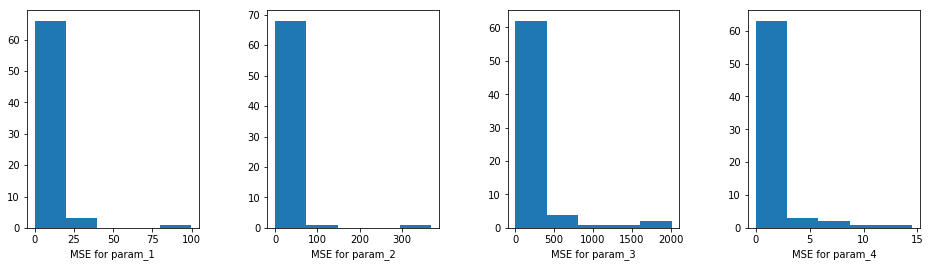

In [14]:
# parameters: x0, L, k, b
# y = 1/ (L + np.exp(-k*(x-x0)))+b

fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_plots= 4
parameters_to_show = ["mse_param_"+str(i+1) for i in range(4)]
print("Mean Squared errors for %d drugs" % df_errors.shape[0])
for i in range(n_plots):
    ax = fig.add_subplot(1, n_plots, i+1)
    ax.hist(df_errors[parameters_to_show[i]], bins=5)
    ax.set_xlabel("MSE for param_"+str(i+1))

**Observations:**
<br> The fitting function was sigmoid_4_parameters: y = 1/ (L + np.exp(-k*(x-x0)))+b
<br> The best predictions are for parameter 4 (b) where the majority of predictions has MSE less than 5
<br> Rather good results are for parameters 1 and 3 with MSE for majority of drugs <20

Mean Absolute errors for 70 drugs


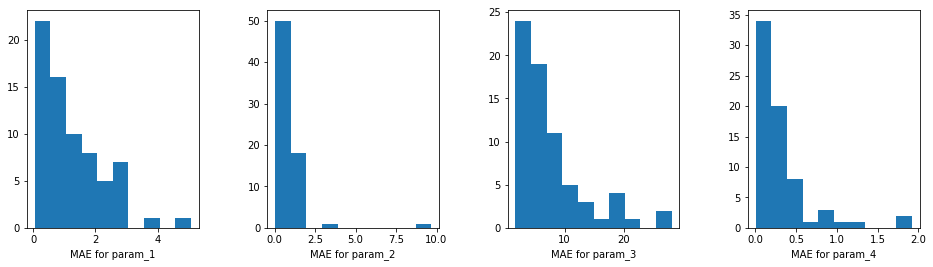

In [15]:
fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
n_plots= 4
print("Mean Absolute errors for %d drugs" % df_errors.shape[0])
parameters_to_show = ["mae_param_"+str(i+1) for i in range(4)]
for i in range(n_plots):
    ax = fig.add_subplot(1, n_plots, i+1)
    ax.hist(df_errors[parameters_to_show[i]])
    ax.set_xlabel("MAE for param_"+str(i+1))

Figures titles: Index_DRUG_ID_COSMIC_ID (COSMIC_ID is a cell line)


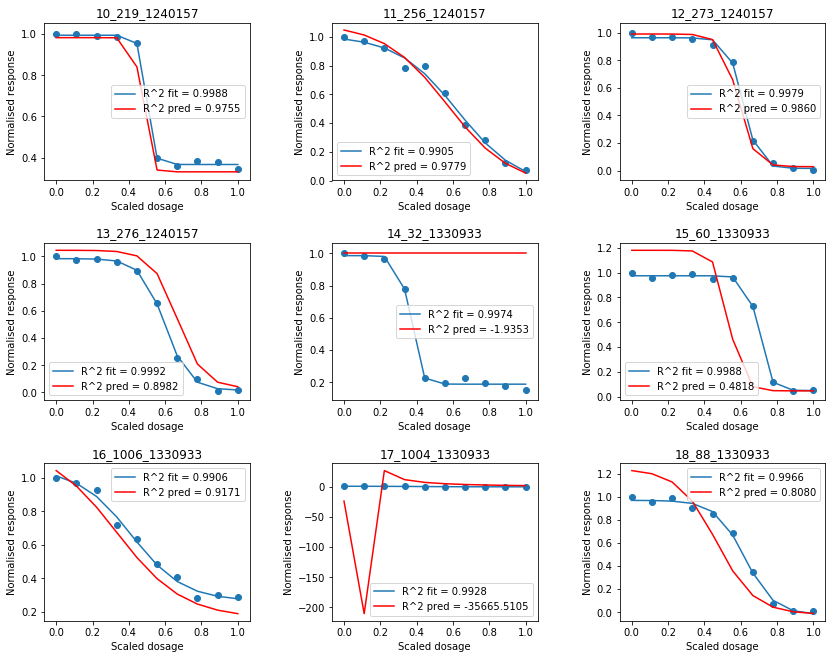

In [41]:
fit_columns = ["param_" + str(i+1) for i in range(4)]
pred_fit_columns = ["pred_param_" + str(i+1) for i in range(4)]
fitting_function = "sigmoid_4_param"

ShowResponseCurvesWithFitting(merged_df, plots_in_row = 3, plots_in_column = 3, x_columns = conc_columns, 
                              y_columns = response_norm, indexes = merged_df.index[10:19], 
                              fitting_function = fitting_function, fitting_parameters = fit_columns,
                             pred_fitting_param = pred_fit_columns)

In [17]:
print("Merged data:", merged_df.shape[0])
print("Merged and Fitted data:", merged_df[merged_df["r2_predicted"]>0.9].shape[0])

Merged data: 2593
Merged and Fitted data: 120


**Observation:**
    Half of the data is predicted well (R2<0.9)

In [18]:
merged_df["DRUG_ID"].nunique(), merged_df[merged_df["r2_predicted"]<0.9]["DRUG_ID"].nunique()

(145, 145)

In [19]:
less_09 = merged_df[merged_df["r2_predicted"]<=0.9]
above_09 = merged_df[merged_df["r2_predicted"]>0.9]

In [20]:
d1 = above_09.groupby("DRUG_ID")[["COSMIC_ID"]].count().reset_index()
d2 = less_09.groupby("DRUG_ID")[["COSMIC_ID"]].count().reset_index()
compare_df = pd.merge(left = d1, right = d2, how= "outer", on = "DRUG_ID").fillna(0).rename(columns = {"COSMIC_ID_x": "above_09", "COSMIC_ID_y": "less_09"})
compare_df["sum"] = compare_df["above_09"]+compare_df["less_09"]
compare_df["percent_success"] = compare_df["above_09"]*100/(compare_df["sum"])
compare_df.sort_values(by="percent_success", ascending=False)

,DRUG_ID,above_09,less_09,sum,percent_success
3,88,9.0,6,15.0,60.000000
4,159,8.0,6,14.0,57.142857
10,275,9.0,7,16.0,56.250000
0,41,12.0,13,25.0,48.000000
5,179,12.0,13,25.0,48.000000
...,...,...,...,...,...
53,172,0.0,7,7.0,0.000000
52,170,0.0,102,102.0,0.000000
51,167,0.0,31,31.0,0.000000
50,165,0.0,37,37.0,0.000000


Number of drugs with number of good predictions above 70%: 0


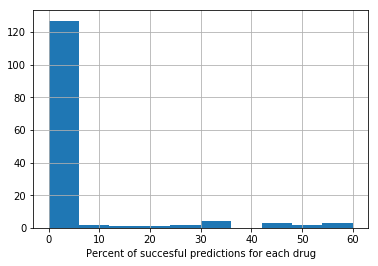

In [21]:
print("Number of drugs with number of good predictions above 70%:", sum(compare_df["percent_success"]>70))
compare_df["percent_success"].hist()
plt.xlabel("Percent of succesful predictions for each drug");

In [22]:
l1 = above_09.groupby("COSMIC_ID")[["DRUG_ID"]].count().reset_index()
l2 = less_09.groupby("COSMIC_ID")[["DRUG_ID"]].count().reset_index()

compare_line = pd.merge(left = l1, right = l2, how= "outer", on = "COSMIC_ID").fillna(0).rename(columns = {"DRUG_ID_x": "above_09", "DRUG_ID_y": "less_09"})
print(compare_line.shape)
compare_line["sum"] = compare_line["above_09"]+compare_line["less_09"]
compare_line["percent_success"] = compare_line["above_09"]*100/(compare_line["sum"])
compare_line[compare_line["sum"]>5].sort_values(by="percent_success", ascending=False)

(827, 3)


,COSMIC_ID,above_09,less_09,sum,percent_success
27,907272,3.0,6.0,9.0,33.333333
61,910706,3.0,6.0,9.0,33.333333
24,906870,2.0,4.0,6.0,33.333333
103,1524415,2.0,5.0,7.0,28.571429
70,924239,3.0,9.0,12.0,25.000000
...,...,...,...,...,...
417,908449,0.0,7.0,7.0,0.000000
446,909701,0.0,6.0,6.0,0.000000
447,909702,0.0,8.0,8.0,0.000000
455,909717,0.0,6.0,6.0,0.000000


In [23]:
compare_line[compare_line["percent_success"]==0].shape[0]

723

In [24]:
print("Data leakage!!!")
df_cells = pd.read_csv(_FOLDER+"Cell_Line_Features_PANCAN_simple_MOBEM.tsv", sep="\t")
df_drugs = df.copy() #filtered drug data
common_cells_drug = list(set(np.array(df_cells.columns[1:], dtype="int"))& set(df_drugs["COSMIC_ID"].values))
print("Number of drugs in filtered drug data: %d, Number of drugs in cell lines data: %d" % \
      (df_drugs["COSMIC_ID"].nunique(), len(common_cells_drug)))
cell_features = pd.read_csv(_FOLDER+"Cell_Line_Features_PANCAN_simple_MOBEM.tsv", sep="\t")
merged_df = MergeDrugCells(df, df_cells)
print("Filtered drug data:", df123.shape)
print("Filtered and fitted drug data:", df.shape)
print("Merged with cell lines properties:", merged_df.shape)

Data leakage!!!
Number of drugs in filtered drug data: 879, Number of drugs in cell lines data: 827
Filtered drug data: (2776, 46)
Filtered and fitted drug data: (2749, 52)
Merged with cell lines properties: (2593, 1099)


Сделать еще:
1) применить функции для другого датасета - не получилось! надо scaling, но какой...
2) посмотреть корреляцию параметров и IC50
3) посмотреть пакет для обработки в R, сделать подборку кривых - сохранить результаты как отедльную таблицу и предсказывать эти параметры

4) что особенного в тех сочетаниях, когда R2>0.9
5) посмотреть другие кернелы и регуляризации
6) посмотреть другие fitting functions
7) auc
8) предсказание диапазона концентраций (min-max), в котором кривые адекватные, и сигмоидной формы

**What I have done during the weak (22.06-01.07):**

    1. Improved filtration - so now I can pass arguments which stages of filtration I can use
    2. Merged drug profiles (found fitting parameters) and cell lines features
    data leakage:
        not all the drug data are present in cell lines (Cell_Line_Features_PANCAN_simple_MOBEM.tsv)
        Number of drugs in filtered drug data: 879, Number of drugs in cell lines data: 827, so 52 records is missing!
        Filtered drug data: (2749, 52), Merged with cell lines properties: (2593, 1099) 5% less data
    3. Trained KernelRidge regression from sklearn
        Half of the data was predicted well (R2>0.9) 1048 from 2593
        but for only 7 drugs 70% of data is predicted so that (R2>0.9)
        Considering Cell lines:
        from 827 lines, percent_success==0 is for 242 drugs
        
    4. Improved visualisation to show all the curves on one graph

### Additional analysis

In [25]:
cell_lines = pd.read_csv(_FOLDER+'Cell_Lines_Details.csv')
cell_lines.head()

,Sample Name,COSMIC identifier,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\rResponse,GDSC\rTissue descriptor 1,GDSC\rTissue\rdescriptor 2,Cancer Type\r(matching TCGA label),Microsatellite \rinstability Status (MSI),Screen Medium,Growth Properties
0,A253,906794,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,NaN,MSS/MSI-L,D/F12,Adherent
1,BB30-HNC,753531,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
2,BB49-HNC,753532,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
3,BHY,753535,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
4,BICR10,1290724,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent


In [26]:
cell_lines["Growth Properties"].value_counts()

Adherent         725
Suspension       244
Semi-Adherent     30
Name: Growth Properties, dtype: int64

In [27]:
cell_328_list = list(set(cell_lines["Sample Name"]) & set(df_328["CELL_LINE_NAME"]))
len(cell_328_list), df_328["CELL_LINE_NAME"].nunique(), cell_lines["Sample Name"].nunique()

NameError: name 'df_328' is not defined

In [ ]:
missing_cells = [cell for cell in df_328["CELL_LINE_NAME"].unique() if cell not in cell_lines["Sample Name"].unique()] 
missing_cells

In [ ]:
cell_328_index = [cell_lines[cell_lines["Sample Name"]==cell].index[0] for cell in df_328["CELL_LINE_NAME"].unique() if cell in cell_lines["Sample Name"].unique()]
# cell_328_index 

In [ ]:
cell_328 = cell_lines.loc[cell_328_index[:5], :].copy()
cell_328

In [ ]:
# df_328["FOLD_DILUTION"].value_counts() - only 1 value
# df_328["MAX_CONC"].value_counts()  - only 1 value

In [ ]:
df_328["MAX_CONC"].value_counts() 

In [ ]:
#
gr = drug_curves.groupby("DRUG_ID")[["MAX_CONC"]].nunique().sort_values("MAX_CONC", ascending=False)

gr_f = df123.groupby("DRUG_ID")[["MAX_CONC"]].nunique().sort_values("MAX_CONC", ascending=False)
print("Number of drugs in original dataset: %d" % gr.shape[0])
print("Number of drugs in filtered dataset: %d" % gr_f.shape[0])

print("\nNumber of drugs with more than 1 concentration in original dataset: %d" % sum(gr['MAX_CONC']>1))
print("Number of drugs with more than 1 concentration in filtered dataset: %d" % sum(gr_f['MAX_CONC']>1))